In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
df=pd.read_csv('MET_OBSERVE_MESSAGE.txt')

In [3]:
df.head()

,站号,站名,时间,气温,降水,气压,风向,风速,湿度
0,59242,来宾,2018-12-14 20:00:00.0,9.6,0.0,1028.6,36.0,2.0,79.0
1,45005,香港,2018-12-14 20:00:00.0,17.3,0.0,1025.7,6.0,1.0,70.0
2,59567,兰屿,2018-12-14 20:00:00.0,19.6,NaN,1023.3,2.0,6.0,100.0
3,59562,台东,2018-12-14 20:00:00.0,21.5,0.0,1025.4,36.0,1.0,72.0
4,59559,恒春,2018-12-14 20:00:00.0,22.8,0.0,1022.8,2.0,6.0,74.0


In [8]:
cs=df[df['站名']=='长沙'].fillna(0)

In [18]:
csc=cs.sort_values(by='时间')

In [24]:
csc.head(3)

,站号,站名,时间,气温,降水,气压,风向,风速,湿度
281313,57687,长沙,2018-11-18 02:00:00.0,8.0,0.6,1021.9,34.0,5.0,97.0
281260,57679,长沙,2018-11-18 02:00:00.0,9.0,1.0,1021.5,32.0,4.0,100.0
280001,57679,长沙,2018-11-18 05:00:00.0,8.3,0.0,1021.8,32.0,5.0,100.0


In [23]:
csc.tail(3)

,站号,站名,时间,气温,降水,气压,风向,风速,湿度
2018102,57687,长沙,2020-07-16 02:00:00.0,24.5,0.0,1003.6,32.0,3.0,95.0
2017543,57687,长沙,2020-07-16 05:00:00.0,24.5,0.0,1003.9,29.0,1.0,95.0
2017482,57687,长沙,2020-07-16 08:00:00.0,25.0,0.0,1004.2,26.0,0.0,94.0


In [19]:
csn=csc[['气温','降水','气压','风向','风速','湿度']]

In [27]:
csn.head()

,气温,降水,气压,风向,风速,湿度
281313,8.0,0.6,1021.9,34.0,5.0,97.0
281260,9.0,1.0,1021.5,32.0,4.0,100.0
280001,8.3,0.0,1021.8,32.0,5.0,100.0
279991,7.5,0.0,1022.3,34.0,6.0,98.0
279161,8.1,5.0,1024.8,32.0,3.0,100.0


In [28]:
csn=csn.reset_index(drop=True)

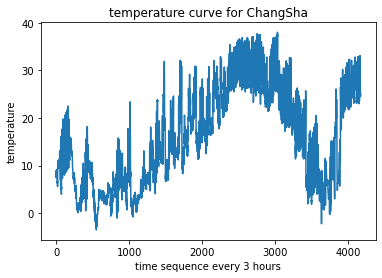

In [30]:
plt.figure()
plt.plot(csn['气温'])
plt.xlabel('time sequence every 3 hours')
plt.ylabel('temperature')
plt.title('temperature curve for ChangSha')
plt.savefig('temp.png')

In [34]:
trSplit=int(0.7*len(csn))

In [36]:
csMean=csn[:trSplit].mean(axis=0)
csStd=csn[:trSplit].std(axis=0)
Nomcs=(csn-csMean)/csStd

In [37]:
Nomcs.head()

,气温,降水,气压,风向,风速,湿度
0,-0.701120,0.031142,0.109462,0.918060,1.569248,0.712954
1,-0.603616,0.192011,0.096501,0.761125,0.961475,0.876378
2,-0.671869,-0.210161,0.106222,0.761125,1.569248,0.876378
3,-0.749872,-0.210161,0.122423,0.918060,2.177022,0.767429
4,-0.691370,1.800701,0.203429,0.761125,0.353701,0.876378


In [95]:
Xtrain=Nomcs[:trSplit]
Xtest=Nomcs[trSplit:]

In [96]:
len(Xtrain)

2916

In [97]:
len(Xtest)

1250

# 1.Temperature prediction

In [98]:
ytrain=Nomcs[:trSplit]['气温']
ytest=Nomcs[trSplit:]['气温']

In [99]:
learning_rate = 0.001
batch_size = 32
epochs = 10

In [100]:
train_dataset= keras.preprocessing.timeseries_dataset_from_array(
    Xtrain,
    ytrain,
    sequence_length=1,
    batch_size=batch_size,
)

In [101]:
test_dataset=keras.preprocessing.timeseries_dataset_from_array(
    Xtest,
    ytest,
    sequence_length=1,
    batch_size=batch_size,
)

In [102]:
for batch in train_dataset.take(1):
    inputs,targets=batch

In [103]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1, 6)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [104]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
92/92 [==============================] - 3s 15ms/step - loss: 0.7147 - val_loss: 0.4202

Epoch 00001: val_loss improved from inf to 0.42018, saving model to model_checkpoint.h5
Epoch 2/10
92/92 [==============================] - 1s 6ms/step - loss: 0.2877 - val_loss: 0.1638

Epoch 00002: val_loss improved from 0.42018 to 0.16383, saving model to model_checkpoint.h5
Epoch 3/10
92/92 [==============================] - 1s 8ms/step - loss: 0.1112 - val_loss: 0.0743

Epoch 00003: val_loss improved from 0.16383 to 0.07432, saving model to model_checkpoint.h5
Epoch 4/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0509 - val_loss: 0.0307

Epoch 00004: val_loss improved from 0.07432 to 0.03065, saving model to model_checkpoint.h5
Epoch 5/10
92/92 [==============================] - 1s 7ms/step - loss: 0.0227 - val_loss: 0.0122

Epoch 00005: val_loss improved from 0.03065 to 0.01224, saving model to model_checkpoint.h5
Epoch 6/10
92/92 [==============================

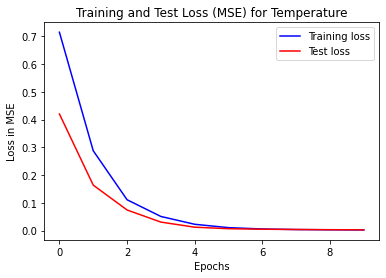

In [105]:
trloss=history.history["loss"]
teloss=history.history["val_loss"]
real_epochs=range(len(trloss))
plt.figure()
plt.plot(real_epochs, trloss, "b", label="Training loss")
plt.plot(real_epochs, teloss, "r", label="Test loss")
plt.title('Training and Test Loss (MSE) for Temperature')
plt.xlabel("Epochs")
plt.ylabel("Loss in MSE")
plt.legend()
plt.savefig('temptraintest1.png')

In [112]:
overall_dataset= keras.preprocessing.timeseries_dataset_from_array(
    Nomcs,
    Nomcs['气温'],
    sequence_length=1,
    batch_size=batch_size,
)

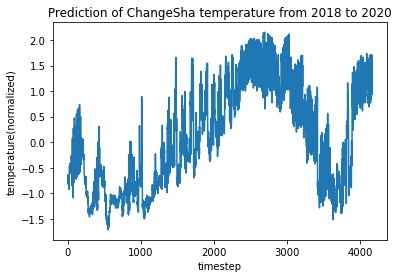

In [113]:
plt.figure()
plt.plot(model.predict(overall_dataset))
plt.xlabel('timestep')
plt.ylabel('temperature(normalized)')
plt.title('Prediction of ChangeSha temperature from 2018 to 2020')
plt.savefig('temppred.png')

# 2. Pressure

In [114]:
ytrain=Nomcs[:trSplit]['气压']
ytest=Nomcs[trSplit:]['气压']

In [115]:
train_dataset= keras.preprocessing.timeseries_dataset_from_array(
    Xtrain,
    ytrain,
    sequence_length=1,
    batch_size=batch_size,
)
test_dataset=keras.preprocessing.timeseries_dataset_from_array(
    Xtest,
    ytest,
    sequence_length=1,
    batch_size=batch_size,
)
overall_dataset= keras.preprocessing.timeseries_dataset_from_array(
    Nomcs,
    Nomcs['气压'],
    sequence_length=1,
    batch_size=batch_size,
)
for batch in train_dataset.take(1):
    inputs,targets=batch

In [116]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 6)]            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [117]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
92/92 [==============================] - 4s 16ms/step - loss: 0.8656 - val_loss: 0.0178

Epoch 00001: val_loss improved from inf to 0.01783, saving model to model_checkpoint.h5
Epoch 2/10
92/92 [==============================] - 1s 8ms/step - loss: 0.8112 - val_loss: 0.0110

Epoch 00002: val_loss improved from 0.01783 to 0.01101, saving model to model_checkpoint.h5
Epoch 3/10
92/92 [==============================] - 1s 8ms/step - loss: 0.7725 - val_loss: 0.0081

Epoch 00003: val_loss improved from 0.01101 to 0.00812, saving model to model_checkpoint.h5
Epoch 4/10
92/92 [==============================] - 1s 8ms/step - loss: 0.7368 - val_loss: 0.0065

Epoch 00004: val_loss improved from 0.00812 to 0.00654, saving model to model_checkpoint.h5
Epoch 5/10
92/92 [==============================] - 1s 7ms/step - loss: 0.7040 - val_loss: 0.0053

Epoch 00005: val_loss improved from 0.00654 to 0.00533, saving model to model_checkpoint.h5
Epoch 6/10
92/92 [==============================

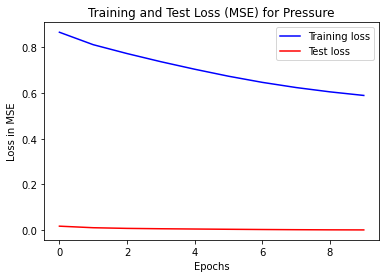

In [118]:
trloss=history.history["loss"]
teloss=history.history["val_loss"]
real_epochs=range(len(trloss))
plt.figure()
plt.plot(real_epochs, trloss, "b", label="Training loss")
plt.plot(real_epochs, teloss, "r", label="Test loss")
plt.title('Training and Test Loss (MSE) for Pressure')
plt.xlabel("Epochs")
plt.ylabel("Loss in MSE")
plt.legend()
plt.savefig('pretraintest1.png')

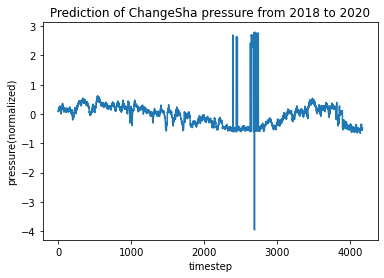

In [119]:
plt.figure()
plt.plot(model.predict(overall_dataset))
plt.xlabel('timestep')
plt.ylabel('pressure(normalized)')
plt.title('Prediction of ChangeSha pressure from 2018 to 2020')
plt.savefig('prepred.png')

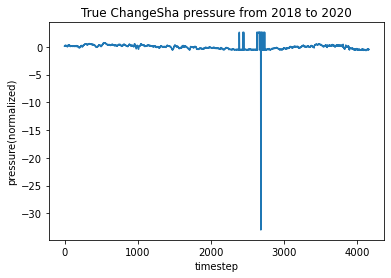

In [120]:
plt.figure()
plt.plot(Nomcs['气压'])
plt.xlabel('timestep')
plt.ylabel('pressure(normalized)')
plt.title('True ChangeSha pressure from 2018 to 2020')
plt.savefig('pretrue.png')

# 3. Humidity

In [121]:
ytrain=Nomcs[:trSplit]['湿度']
ytest=Nomcs[trSplit:]['湿度']

In [122]:
train_dataset= keras.preprocessing.timeseries_dataset_from_array(
    Xtrain,
    ytrain,
    sequence_length=1,
    batch_size=batch_size,
)
test_dataset=keras.preprocessing.timeseries_dataset_from_array(
    Xtest,
    ytest,
    sequence_length=1,
    batch_size=batch_size,
)
overall_dataset= keras.preprocessing.timeseries_dataset_from_array(
    Nomcs,
    Nomcs['湿度'],
    sequence_length=1,
    batch_size=batch_size,
)
for batch in train_dataset.take(1):
    inputs,targets=batch

In [123]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 6)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [124]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
92/92 [==============================] - 3s 16ms/step - loss: 0.5661 - val_loss: 0.5975

Epoch 00001: val_loss improved from inf to 0.59749, saving model to model_checkpoint.h5
Epoch 2/10
92/92 [==============================] - 1s 8ms/step - loss: 0.1934 - val_loss: 0.1725

Epoch 00002: val_loss improved from 0.59749 to 0.17249, saving model to model_checkpoint.h5
Epoch 3/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0520 - val_loss: 0.0453

Epoch 00003: val_loss improved from 0.17249 to 0.04529, saving model to model_checkpoint.h5
Epoch 4/10
92/92 [==============================] - 1s 7ms/step - loss: 0.0141 - val_loss: 0.0126

Epoch 00004: val_loss improved from 0.04529 to 0.01262, saving model to model_checkpoint.h5
Epoch 5/10
92/92 [==============================] - 1s 7ms/step - loss: 0.0046 - val_loss: 0.0058

Epoch 00005: val_loss improved from 0.01262 to 0.00578, saving model to model_checkpoint.h5
Epoch 6/10
92/92 [==============================

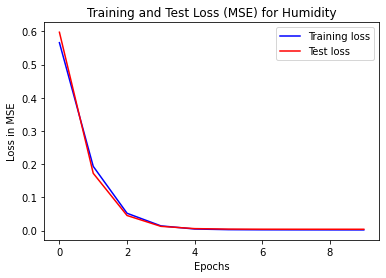

In [125]:
trloss=history.history["loss"]
teloss=history.history["val_loss"]
real_epochs=range(len(trloss))
plt.figure()
plt.plot(real_epochs, trloss, "b", label="Training loss")
plt.plot(real_epochs, teloss, "r", label="Test loss")
plt.title('Training and Test Loss (MSE) for Humidity')
plt.xlabel("Epochs")
plt.ylabel("Loss in MSE")
plt.legend()
plt.savefig('humtraintest1.png')

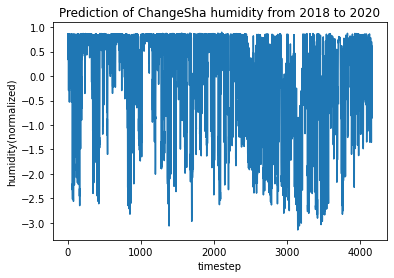

In [126]:
plt.figure()
plt.plot(model.predict(overall_dataset))
plt.xlabel('timestep')
plt.ylabel('humidity(normalized)')
plt.title('Prediction of ChangeSha humidity from 2018 to 2020')
plt.savefig('humpred.png')

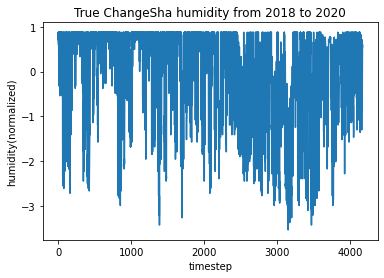

In [127]:
plt.figure()
plt.plot(Nomcs['湿度'])
plt.xlabel('timestep')
plt.ylabel('humidity(normalized)')
plt.title('True ChangeSha humidity from 2018 to 2020')
plt.savefig('humtrue.png')